# HW5 - Explore Wikipedia's hyperlinks network

####  Importing the necessary libraries

In [1]:
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import queue
import statistics 
from queue import PriorityQueue
from tqdm import tqdm 
from collections import deque
from time import time
import queue

import functions

# RQ1


Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them. Then, provide its basic information:

* Is the graph directed?
* How many articles are we considering?
* How many hyperlinks between pages exist?
* Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?
* Visualize the nodes' degree distribution

----

### Building the graph

In [2]:
# creating the graph
G = nx.MultiDiGraph()
nodes = defaultdict(dict)

In [3]:
# the datasets
names = 'wiki-topcats-page-names.txt'
categories = 'wiki-topcats-categories.txt'
links = 'wikigraph_reduced.csv'

In [4]:
# taking in account the file **categories**, filtering its values and saving it in a dictionary

categories_list = defaultdict(list)
multiplecat = defaultdict(list)

with open(categories) as file:
    
    for line in file:
        line = line.split()
        cat = line[0].split(':')[1].strip(';')
        pages = list(map(int, line[1:len(line)]))
        
        # Filtering categories
        if len(pages) >= 5000 and len(pages) <= 30000:
            categories_list[cat] = pages
            
            for i in range(len(pages)):
                multiplecat[pages[i]].append(cat) # multiplecat = {page_number = [list_of_categories]}


In [5]:
# this is the list of all the categories we are taking in account
remaining = list(categories_list.keys())

In [6]:
# Selecting at random one category when a page belongs to more than one

for page in multiplecat.keys():
    if len(multiplecat[page]) != 1:
        nodes[page]['category'] = multiplecat[page][random.randint(0,len(multiplecat[page])-1)]
    else:
        nodes[page]['category'] = multiplecat[page][0]

In [7]:
# saving the page names

with open(names) as file:
    for line in file:
        line = line.split()
        number = int(line[0])
        name = ' '.join(line[1:])
        if number in multiplecat.keys():
            nodes[number]['name'] = name
            
            # nodes = {{page_number: {'name': page_name, 'category': page_category}}

In [8]:
# adding nodes to the graph from the format 
# [(page_number, {'name': page_name, 'category': page_category})]

for key in nodes.keys():
    G.add_nodes_from([(int(key), nodes[key])])

In [9]:
# adding edges from the given links

with open(links) as file:
    file.readline()
    for line in file:
        line = line.split()
        origin = int(line[1])
        destination = int(line[2])
        if origin in nodes.keys() and destination in nodes.keys():
            G.add_edges_from([(origin,destination)])

In [10]:
print(list(nodes.items())[0:5])

[(22860, {'category': 'English_footballers', 'name': 'George Wright (footballer)'}), (28411, {'category': 'Association_football_defenders', 'name': 'Gilbert Ovens'}), (28961, {'category': 'English_footballers', 'name': 'Stuart Wardley'}), (28979, {'category': 'English_footballers', 'name': 'Bryan King'}), (29264, {'category': 'Association_football_defenders', 'name': 'Paul Bowgett'})]


----

The graph is directed because web links are by definition directional. In addition, we can check this feature by viewing that the number of unique origins is different from the number of unique destinations as shown below. Furthermore, we already know from the text assignment that the nodes are categorized in *sources* and *targets*.  

In [11]:
df = pd.read_csv(links, sep='\t')
df.drop({'Unnamed: 0'},axis=1,inplace=True)
df.rename(columns={'0':'origin', '1':'destination'}, inplace=True)

In [12]:
# let's see how the dataframe is structured
df.head()

,origin,destination
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


In [13]:
df.origin.nunique() == df.destination.nunique()

False

------

In [14]:
functions.graphInfo(G)

We have a graph containing 149794 articles and 483094 hyperlinks.
The average number of links per page is: 3.2251
The graph density is 2.153008313619922e-05


A graph is dense if the number of edges is close to the maximal number of edges that it can have. For directed graph that number is $$ M^* = {2\cdot {|V| \choose 2}}$$ In other words the graph is dense if the ratio $|E|/M^*$ is close to 1.

In our case we can affirm that the graph is sparse. 

-----
#### Nodes degree distribution

We are going here to plot the degree distributions for the indegrees and the outdegrees.


In [14]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

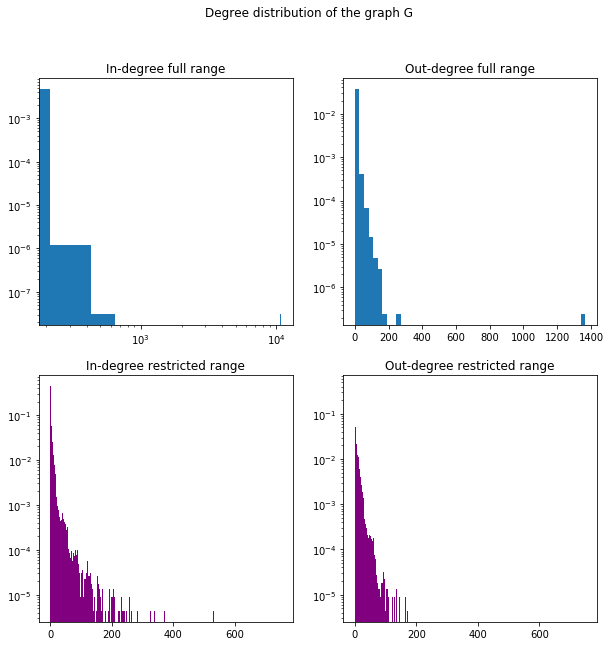

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.rc('legend', fontsize=6)   
fig.suptitle('Degree distribution of the graph G')

axs[0,0].set_xscale('log')
axs[0,0].hist(in_degrees, log = True, density = True, bins = 50)
axs[0,0].set_title('In-degree full range')

axs[1,0].hist(in_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,0].set_title('In-degree restricted range')

axs[0,1].hist(out_degrees, log = True, density = True, bins = 50)
axs[0,1].set_title('Out-degree full range')

axs[1,1].hist(out_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,1].set_title('Out-degree restricted range')

plt.show()

The first two plots are considering the whole range on the $x$-axis and the second ones are focused on a small subset of the axis that contains most of the values. Moreover, the first plot is on the log scale in order to clearly see all the values. 

We can see that the degree distribution has most of its value before 300, but also a long tail due to some outliers. In addition it seems that the distribution follows a power law $p\sim k^\alpha$.

# RQ2

Define a function that takes in input:

* A page v
* A number of clicks d
and returns the set of all pages that a user can reach within d clicks.

-----

In order to find the set of pages that we can reach in `nr_clicks` we search for those nodes that are connected between themselves (beeing origin and destination) and that are at a specific distance from the original page. 

In [16]:
functions.RQ2(95,3,df)

,0
0,1595904
1,1182721
2,1061891
3,1067523
4,1060361
...,...
126,1058280
127,1761772
128,139762
129,1061882


# RQ3

Define a function that takes in input:

* A category C
* A set of pages in C, p = {p1, ..., pn}

and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

-----

Let $C$ be the chosen category, $S$ the subset of pages inside that category, $G_C$ the subgraph induced by $C$ and $\hat v$ the most central node according to the indegree cetrality.

In order to solve `RQ3` we implemented a heuristic that creates a spanning tree $T$ from $\hat v$ to all the pages in $S$.

Given this tree, for every node $u$ in $T$ we can have two cases:
1. the node $u$ has at least an out edge, so it is part of a path ;
2. the node $u$ does not have an out edge, so it is a dead end.

In the second case, if $\exists(u,w)\in G_C$ with $w\in T$, such that if we add $(u,w)$ to $T$ it is not a dead end anymore, we can add $(u,w)$ to $T$.

If this edge does not exists, we imagine that our surfer start again its journey at the starting page, so we add an edge from $u$ to $\hat v$.   

In [17]:
# these are all the categories we are working on
print(', '.join(remaining))

English_footballers, The_Football_League_players, Association_football_forwards, Association_football_midfielders, Association_football_defenders, Harvard_University_alumni, Major_League_Baseball_pitchers, Members_of_the_United_Kingdom_Parliament_for_English_constituencies, Indian_films, Year_of_death_missing, Rivers_of_Romania, Main_Belt_asteroids, Asteroids_named_for_people, English-language_films, American_films, American_television_actors, American_film_actors, Debut_albums, Black-and-white_films, Year_of_birth_missing, Place_of_birth_missing_(living_people)


In [18]:
functions.RQ3(G,'Harvard_University_alumni', df, nodes, None)

---------------------------------------------
The approximated number of clicks is 306


# RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

Let $v$ and $u$ two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect $u$ and $v$?

----

The main idea is, given two nodes, we build the graph induced by all possible paths from those two nodes and then we use Karger algorithm to approximate the min-cut.

The running time depends heavily on the choice of $N$, i.e. the number of times we run the Karger algorithm. 

In [15]:
C1 = 'The_Football_League_players' 
C2 = 'English_footballers'
node_u = 79082
node_v = 79457
N = 10

In [17]:
functions.RQ4(G, C1, C2, node_u, node_v, N,nodes)

'The minimum number of hyperlinks to remove in order to disconnect node u and node v is 1'

# RQ5

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.


----

In this exercise we compute the pairwise distances between the categories using `BFS`.

In order to be more efficient, for each couple of categories, a subgraph induced by those two is created and the distances are evaluated each time on that. 

This could take about 20 minutes.

In [21]:
functions.RQ5(G,'Association_football_forwards',nodes,remaining)

Computing distances...
1 out of 21 categories.
2 out of 21 categories.
3 out of 21 categories.
4 out of 21 categories.
5 out of 21 categories.
6 out of 21 categories.
7 out of 21 categories.
8 out of 21 categories.
9 out of 21 categories.
10 out of 21 categories.
11 out of 21 categories.
12 out of 21 categories.
13 out of 21 categories.
14 out of 21 categories.
15 out of 21 categories.
16 out of 21 categories.
17 out of 21 categories.
18 out of 21 categories.
19 out of 21 categories.
20 out of 21 categories.
21 out of 21 categories.
Reached solution in 756.845092 seconds


{'Debut_albums': 1,
 'Major_League_Baseball_pitchers': 2,
 'American_films': 4,
 'Year_of_birth_missing': 4,
 'Rivers_of_Romania': 5,
 'Black-and-white_films': 5,
 'Year_of_death_missing': 5.0,
 'The_Football_League_players': 6.0,
 'Association_football_forwards': 6,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 6.0,
 'English-language_films': 7,
 'Association_football_defenders': 7.0,
 'Association_football_midfielders': 7.0,
 'English_footballers': 7,
 'Place_of_birth_missing_(living_people)': 8.0,
 'American_television_actors': 9.0,
 'American_film_actors': 12.0,
 'Asteroids_named_for_people': inf,
 'Indian_films': inf,
 'Main_Belt_asteroids': inf,
 'Harvard_University_alumni': inf}

# RQ6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

---

#### 1. Create the new graph

We created a new graph where each node represents a category and there is an edge between two nodes if in original graph there was at least one edge from a node in that category to one in another category. 

In [11]:
catG = nx.DiGraph()

In [12]:
# adding the nodes

i = 0
dic = dict()
for cat in remaining:
    catG.add_nodes_from([(i, {'category': cat})])
    dic[cat] = i
    i += 1

In [13]:
# adding the edges

for cat in remaining:
    for node in categories_list[cat]:
        for edge in G.out_edges(node):
            origin_cat = G.nodes[edge[0]]['category']
            dest_cat = G.nodes[edge[1]]['category']
            if origin_cat != dest_cat:
                catG.add_edge(dic[origin_cat], dic[dest_cat])

#### 2. PageRank

In [14]:
results = functions.RQ6(catG)

|------------------|
| PageRank results |
|------------------|

Score: 7.26 Category: American_films
Score: 5.54 Category: Year_of_birth_missing
Score: 5.52 Category: Year_of_death_missing
Score: 5.52 Category: English-language_films
Score: 5.51 Category: American_television_actors
Score: 5.51 Category: American_film_actors
Score: 5.51 Category: Place_of_birth_missing_(living_people)
Score: 5.5 Category: Harvard_University_alumni
Score: 5.28 Category: Members_of_the_United_Kingdom_Parliament_for_English_constituencies
Score: 5.09 Category: Association_football_forwards
Score: 5.06 Category: Debut_albums
Score: 4.83 Category: Association_football_midfielders
Score: 4.8 Category: English_footballers
Score: 4.58 Category: Black-and-white_films
Score: 4.56 Category: Association_football_defenders
Score: 4.32 Category: The_Football_League_players
Score: 3.79 Category: Major_League_Baseball_pitchers
Score: 3.58 Category: Indian_films
Score: 3.28 Category: Main_Belt_asteroids
Score: 2.74 Cate

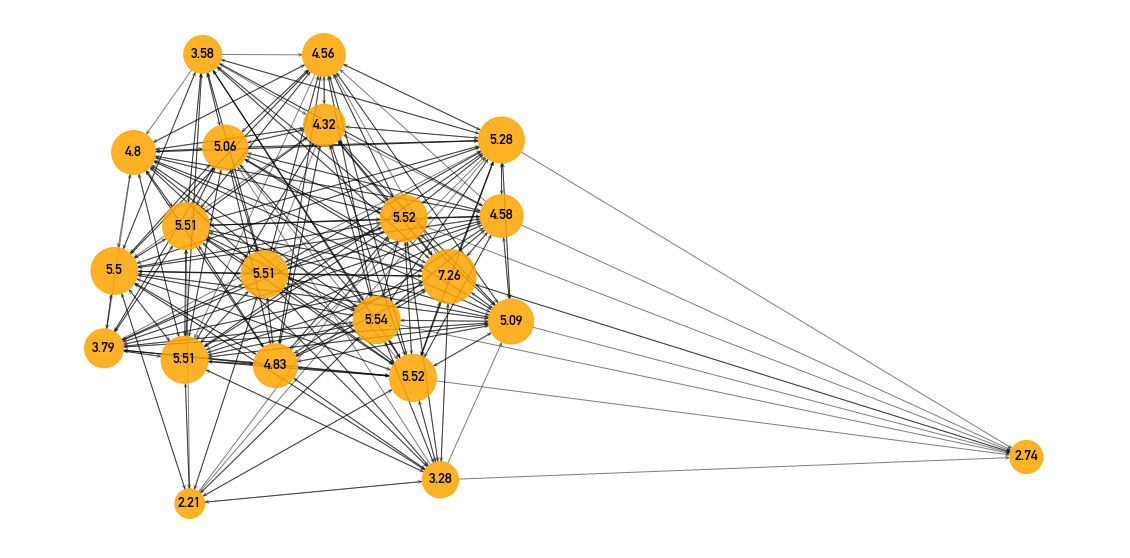

In [15]:
# plotting the graph

functions.plotPR(catG, results)